In [ ]:
!jupyter nbconvert --to html /content/LatentDirichletAllocation.ipynb.ipynb

In [ ]:
!pip install pymc
!pip install git+https://github.com/codelucas/newspaper.git

# TASK 1

## **Function definitions**

In [2]:
import gensim
import nltk
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
sns.set_context("poster")

def flatten(t):
  return [item for sublist in t for item in sublist]

def lemmatize_stemming(text):                                                   
  ps = nltk.stem.porter.PorterStemmer()
  return ps.stem(text)

# Tokenize and lemmatize the text
def preprocess(text):
  result=[]
  for token in gensim.utils.simple_preprocess(text) :
      if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
          result.append(lemmatize_stemming(token))
          
  return result

def to_one_word_array(v):
    docs = list()
    for w in v.toarray():
        words = list()
        for d, n in enumerate(w):
            for j in range(n):
                words.append(d)
        docs.append(words)
    return docs
  

def plot_words_per_topic(Z,ax=None):
  if ax is None:
      plt.clf()
      fig, ax = plt.subplots(1,1)
  words = Z
  topic_dist = dict()
  for k_i in words:
      for k in k_i:
          if k not in topic_dist:
              topic_dist[k] = 0
          topic_dist[k] += 1
  ax.bar(topic_dist.keys(), topic_dist.values())
  ax.set_xlabel("Topics")
  ax.set_ylabel("Counts")
  ax.set_title("Document words per topics")
  plt.show()

def plot_word_dist(phi, ax=None):
  topics = phi.value
  if ax is None:
      plt.clf()
      fig, ax = plt.subplots((len(topics)+1)/2, 2, figsize=(10,10))
  for i, t in enumerate(topics):
      ax[i/2][i%2].bar(range(len(t[0])), t[0])
      ax[i/2][i%2].set_title("Topic %s" % i)
  plt.suptitle("Vocab word proportions per topic")
  fig.subplots_adjust(hspace=0.5, wspace=0.5)

def plot_data(self):
  plt.clf()
  plt.matshow(data, fignum=1000, cmap=plt.cm.Reds)
  plt.gca().set_aspect('auto')
  plt.xlabel("Words")
  plt.ylabel("Documents")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Topic links**

In [3]:
from newspaper import Article

sport =      ['https://en.wikipedia.org/wiki/Cricket',
              'https://en.wikipedia.org/wiki/Tennis',
              'https://en.wikipedia.org/wiki/Football',
              'https://en.wikipedia.org/wiki/Basketball']

electronic = ['https://en.wikipedia.org/wiki/Capacitor',
              'https://en.wikipedia.org/wiki/Integrated_circuit',
              'https://en.wikipedia.org/wiki/Resistor',
              'https://en.wikipedia.org/wiki/Transistor']

planet =     ['https://en.wikipedia.org/wiki/Venus',
              'https://en.wikipedia.org/wiki/Mars',
              'https://en.wikipedia.org/wiki/Uranus',
              'https://en.wikipedia.org/wiki/Jupiter']

religion =   ['https://en.wikipedia.org/wiki/Christianity',
              'https://en.wikipedia.org/wiki/Islam',
              'https://en.wikipedia.org/wiki/Judaism',
              'https://en.wikipedia.org/wiki/Buddhism']


topic_links = {"sport":sport, "religion": religion,  "planet":planet, "electronic":electronic}

**Text preprocessing: stemming and special characters removal**

In [4]:
topic_texts = []
preprocessed_files = []

for topic in topic_links:
  topic_texts.clear()
  for article_link in topic_links[topic]:
    article = Article(url="%s" % article_link)
    article.download()
    article.parse()
    pp_text = preprocess(article.text)  #stem every word and remove special characters
    length = 500                                                                
    txt = " ".join(pp_text[0:length])   #use the first 100 eligibile words from every wikipedia page
    topic_texts.append(txt.split())
  temp = topic_texts.copy()
  preprocessed_files.append(temp)       #save all preprocessed texts in preprocesed_files



**Text processing: remove sparse words**

In [6]:
processed_files = []                                          
filtered_topic = []
final_topic = []
K = 4    #number of topics

print("Dictionaries for all %i topics. Topic index is just related to the order of processing and doesn't reflect the final clustering of documents on topics."%K)
for idx,topic_files in enumerate(preprocessed_files):
  n = len(topic_files)       #number of documents in the topic
  unique_files = flatten([list(set(file)) for file in topic_files])    #append unique words from every document
  dictionary = dict(Counter(unique_files))     #create dictionary of the unique words

  #keep words that are common in at least a half of the documents from the same topic
  words_to_keep = [pair[0] for pair in list(filter(lambda x: x[1] > n/2,sorted(dictionary.items(), key=lambda x: x[1], reverse=True)))] 
  for i,doc in enumerate(topic_files):
    temp = [i for i in doc if i in words_to_keep]
    filtered_topic.append(temp)

  # dictionary of filtered words for this particular topic
  filtered_dictionary = dict(Counter(flatten(filtered_topic)))

  # set threshold for word incidence to 1% of the total number of words for this topic
  sparsity_threshold = len(flatten(filtered_topic))*0.01     

  # save the words that have incidence higher than the sparcity threshold    
  dense_words = [pair[0] for pair in list(filter(lambda x: x[1] > sparsity_threshold,sorted(filtered_dictionary.items(), key=lambda x: x[1], reverse=True)))]  
  for i,doc in enumerate(filtered_topic):
    temp = [i for i in doc if i in dense_words]
    final_topic.append(temp)

  temp = final_topic.copy()                                             
  processed_files.append(temp)     #save all processed texts in processed_files
  final_dictionary = dict(Counter(flatten(final_topic)))
  print("dictionary for topic %i: "%idx, {k: v for k, v in sorted(final_dictionary.items(), key=lambda item: item[1], reverse=True)})
  filtered_topic.clear()
  final_topic.clear()


Dictionaries for all 4 topics. Topic index is just related to the order of processing and doesn't reflect the final clustering of documents on topics.
dictionary for topic 0:  {'ball': 70, 'game': 54, 'play': 45, 'footbal': 41, 'player': 34, 'team': 30, 'sport': 23, 'centuri': 17, 'court': 15, 'point': 14, 'origin': 13, 'club': 12, 'rule': 12, 'world': 12, 'field': 11, 'england': 11, 'popular': 11, 'goal': 10, 'modern': 10, 'score': 9, 'includ': 9, 'line': 8, 'refer': 8, 'call': 7, 'time': 7, 'mean': 7, 'histori': 6, 'earli': 6}
dictionary for topic 1:  {'christian': 33, 'religion': 26, 'teach': 22, 'term': 16, 'centuri': 15, 'earli': 15, 'world': 14, 'tradit': 14, 'practic': 14, 'mean': 13, 'follow': 12, 'includ': 12, 'life': 11, 'religi': 11, 'abraham': 9, 'popul': 9, 'refer': 9, 'form': 9, 'known': 7, 'major': 7, 'call': 7, 'later': 7, 'state': 7, 'east': 7, 'asia': 7, 'faith': 7, 'origin': 7, 'monotheist': 6, 'gener': 6, 'exist': 6, 'africa': 6, 'belief': 6, 'interpret': 6, 'histor

**Vectorize words**

In [7]:
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer()
processed_docs = [" ".join(file) for file in flatten(processed_files)]          
v = vectorizer.fit_transform(processed_docs)
inv_voc = {v: k for k, v in vectorizer.vocabulary_.items()}   #create vocabulary of all the processed words

documents = to_one_word_array(v)                                   

In [8]:
print("Total number of words in all the documents:          ",len(flatten(documents)))
print("Total number of distinct words in all the documents: ",len(inv_voc))

Total number of words in all the documents:           1795
Total number of distinct words in all the documents:  112


## **Setting the model parameters**

## α and β represent the prior beliefs about the corpus befor the model is trained


*  A low value for α was chosen because every document is composed mainly of one topic. The majority of the probablity mass is in the corners of the simplex.



In [9]:
import numpy as np
                                                                                
K = 4                                  # number of topics
V = len(inv_voc)                       # number of words in the vocabulary
M = len(documents)                     # number of documents  
N_m = [len(doc) for doc in documents]  # number of words in every doc            
 
                                                  
iterations = 5000
burn_in = 0

# a small value of alpha was chosen because documents are made of one or a few topics.
alpha = np.ones(K) * 1/K 
beta = np.ones(V) * 1/K                                                         
print("K = ", K)
print("V = ", V)
print("M = ", M)

K =  4
V =  112
M =  16


## **LDA Model**

In [10]:
# document distribution over topics
# completed Dirichlet was used in order to add an additional probability which will make the sum of all probabilities to be alpha
theta = pm.Container([pm.CompletedDirichlet("theta_%i" % d, pm.Dirichlet("ttheta_%i" % d, theta=alpha)) for d in range(M)])    
                                                                                                                                
# topic distribution over words
# completed Dirichlet was used in order to add an additional probability which will make the sum of al probabilities to be beta
phi = pm.Container([pm.CompletedDirichlet("phi_%s" % k, pm.Dirichlet("pphi_%s" % k, theta=beta)) for k in range(K)])  
                                                                                                                      
Wd = [len(doc) for doc in documents]    #list with length of all the documents                                                                                            

# Will draw words from every document and it will assign a topic according to the probabilities from theta
Z = pm.Container([pm.Categorical("z_%i" % d,
                                      p = theta[d],                                                              
                                      size = Wd[d],                                                              
                                      value = np.random.randint(K,size=Wd[d]))      
                        for d in range(M)])


#given the topic draws in z,the model will select a random word out of its topic distribution in phi
W = pm.Container([pm.Categorical("w_%i_%i" % (d,i),                                          
                                      p = pm.Lambda("phi_z_%i_%i" % (d,i),                                        
                                                    lambda z=Z[d][i], phi=phi : phi[z]),
                                      value=documents[d][i],
                                      observed=True)  
                      for d in range(M) for i in range(Wd[d])])

model = pm.Model([theta, phi, Z, W])
mcmc = pm.MCMC(model)
mcmc.sample(iterations, burn=burn_in)

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 5000 of 5000 complete in 132.7 sec

<Figure size 432x288 with 0 Axes>

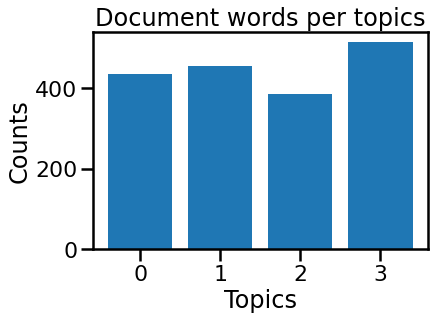

In [11]:
plt.clf()
fig, ax = plt.subplots(1,1)
words = Z.value
topic_dist = dict()
for k_i in words:
    for k in k_i:
        if k not in topic_dist:
            topic_dist[k] = 0
        topic_dist[k] += 1
ax.bar(topic_dist.keys(), topic_dist.values())
ax.set_xlabel("Topics")
ax.set_ylabel("Counts")
ax.set_title("Document words per topics")
plt.show()

In [12]:
print("Top 5 words for every topic:\n")
topics = []
t=[]
for k in range(K):
  t.clear()
  for i, j in enumerate(mcmc.trace('phi_%i'%k)[-1][0]):
    t.append([inv_voc[i], j])
  temp = t.copy()
  temp.sort(key=lambda x:x[1], reverse = True)
  print("Topic %i: "%k)
  for pair in temp[:5]:
    print(pair)
  print("")

Top 5 words for every topic:

Topic 0: 
['metal', 0.12671189865696508]
['mean', 0.1090590556289564]
['type', 0.07378044890469142]
['score', 0.055320975795624984]
['compon', 0.05222727442383175]

Topic 1: 
['life', 0.0824754488192014]
['religion', 0.06754011287963439]
['physic', 0.055385916035098355]
['suggest', 0.05013077797576808]
['planet', 0.04679128721612772]

Topic 2: 
['mytholog', 0.12549203289657004]
['earli', 0.07383875687939977]
['model', 0.0637098021584985]
['form', 0.061002301873164716]
['game', 0.05568013436150991]

Topic 3: 
['form', 0.18246705029527546]
['christian', 0.07367738875206514]
['exist', 0.06300533309840058]
['atmospher', 0.05202727074399172]
['line', 0.048638095129878996]



In [13]:

counts = []
print("Topic prediction for each document:\n")
for d in range(len(documents)):
    # save the last 100 traces for z
    pred = mcmc.trace('z_%i'%d)[-100:]                                          
    for p in pred:
      # create list of list with the results of every word topic drew from every sentence.
      counts.append(np.bincount(p, minlength=4))                               
    avg_count = list(np.sum(counts,axis=0)/len(pred))
    print("Document %i -> "%d," Topic %i" %avg_count.index(max(avg_count)))
    print("Topic distribution for document %i"%d,avg_count)
    print("")
    counts.clear()

Topic prediction for each document:

Document 0 ->   Topic 0
Topic distribution for document 0 [38.48, 29.28, 30.59, 5.65]

Document 1 ->   Topic 1
Topic distribution for document 1 [1.38, 74.62, 3.0, 52.0]

Document 2 ->   Topic 3
Topic distribution for document 2 [62.58, 28.42, 14.0, 64.0]

Document 3 ->   Topic 2
Topic distribution for document 3 [39.0, 0.0, 55.0, 14.0]

Document 4 ->   Topic 1
Topic distribution for document 4 [17.26, 54.65, 0.09, 31.0]

Document 5 ->   Topic 1
Topic distribution for document 5 [0.0, 33.05, 32.95, 33.0]

Document 6 ->   Topic 3
Topic distribution for document 6 [17.0, 7.26, 25.23, 41.51]

Document 7 ->   Topic 2
Topic distribution for document 7 [18.86, 2.22, 35.32, 19.6]

Document 8 ->   Topic 1
Topic distribution for document 8 [52.04, 81.38, 2.58, 31.0]

Document 9 ->   Topic 2
Topic distribution for document 9 [16.0, 16.96, 44.0, 9.04]

Document 10 ->   Topic 2
Topic distribution for document 10 [19.43, 0.57, 56.77, 31.23]

Document 11 ->   Top

# TASK 2

## **Topic-based similarity between documents**


**Cosine Similarity**  captures the orientation of the documents not the magnitude and 2 documents which have a big difference in number of words could score high on the similarity if the sets of words for both have many elements in common.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

doc_names = ['Sports_1','Sports_2','Sports_3','Sports_4', 'Electronics_1', 'Electronics_2', 'Electronics_3', 'Electronics_4', 'Planets_1', 'Planets_2', 'Planets_3', 'Planets_4', 'Religions_1', 'Religions_2', 'Religions_3', 'Religions_4']

doc_term_matrix = v.todense()
words_df = pd.DataFrame(doc_term_matrix, 
                  columns=vectorizer.get_feature_names(), 
                  index = doc_names)

print("Cosine similarity matrix\n")
similarity = cosine_similarity(words_df, words_df)
sim_df = pd.DataFrame(similarity, columns = doc_names)
sim_df.insert(0,"---------",doc_names, allow_duplicates=True)
sim_df = sim_df.set_index("---------")
print(sim_df.to_string())


Cosine similarity matrix

               Sports_1  Sports_2  Sports_3  Sports_4  Electronics_1  Electronics_2  Electronics_3  Electronics_4  Planets_1  Planets_2  Planets_3  Planets_4  Religions_1  Religions_2  Religions_3  Religions_4
---------                                                                                                                                                                                                        
Sports_1       1.000000  0.807566  0.603160  0.834864       0.062369       0.133510       0.069877       0.097548   0.009841   0.006782   0.008452   0.025335     0.031211     0.013937     0.002084     0.068537
Sports_2       0.807566  1.000000  0.540553  0.671859       0.070801       0.115379       0.058151       0.120021   0.012347   0.006078   0.010100   0.029193     0.027971     0.032474     0.002802     0.035830
Sports_3       0.603160  0.540553  1.000000  0.620915       0.049771       0.082598       0.039830       0.068544   0.001149   0.00396

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## **Topic prediction for a new document**


**Remove stopwords and apply stemming to the document**

In [15]:
new_link = 'https://en.wikipedia.org/wiki/Pluto'

new_text = []
preprocessed_files = []

test_article = Article(url="%s" % new_link)
test_article.download()
test_article.parse()

#stem every word and remove special characters
pp_text = preprocess(test_article.text)   
length = 500           
#use the first 500 eligibile words from every wikipedia page                                                     
new_text = " ".join(pp_text[0:length])   
new_doc = pp_text[0:length]

**Remove sparse words and vectorize the document**

In [16]:
final_test_doc = []

# dictionary of filtered words for this particular topic
temp_dictionary = dict(Counter(new_doc))                                        

# set threshold for word incidence to 1% of the number of words 
sparcity_threshold = len(new_doc)*0.01                                          

# save the words that have incidence higher than the sparcity threshold
dense_words = [pair[0] for pair in list(filter(lambda x: x[1] > sparcity_threshold,sorted(temp_dictionary.items(), key=lambda x: x[1], reverse=True)))]  
final_test_doc = [i for i in new_doc if i in dense_words]


In [17]:
test_words = [inv_voc[value] for value in inv_voc]

#extract the words that are that can be found in the vocabulary used for training
common_words = [i for i in final_test_doc if i in test_words]                   
test_words = " ".join(common_words)

#create a new preprocessed corpus with training and test documents
all_words = processed_docs.copy()
all_words.append(test_words)                                                    

#vectorize all the words documents
#and keep only the test documents
v_all = vectorizer.fit_transform(all_words)                                     
all_documents = to_one_word_array(v_all)
test_documents = [all_documents[-1]]                                            
test_text = " ".join(common_words)

**Test model**

In [18]:
wd_test = [len(doc) for doc in test_documents]        

#both priors will be set to 1 for the training set
alpha = np.ones(K)                                                              
beta = np.ones(V)

D_test = len(test_documents)
wd_test = [len(doc) for doc in test_documents]

theta_test = pm.Container([pm.CompletedDirichlet("theta_t_%s" % i, pm.Dirichlet("ptheta_t_%s" % i, theta=alpha)) for i in range(D_test)])    
z_test = pm.Container([pm.Categorical('z_t_%s' % d, p = theta_test[d], size=wd_test[d], value=np.random.randint(K, size=wd_test[d])) for d in range(D_test)])
   
w_test = pm.Container([pm.Categorical("w_t_%i_%i" % (d,i), p = pm.Lambda('phi_z_t_%i_%i' % (d,i), lambda z=z_test[d][i], phi=phi: phi[z]),
                    value=test_documents[d][i], observed=True) for d in range(D_test) for i in range(wd_test[d])])

model_test = pm.Model([theta_test, z_test, w_test])
mcmc_test = pm.MCMC(model_test)
mcmc_test.sample(iter=5000, burn=100)

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 5000 of 5000 complete in 4.0 sec

**Topic prediction and the distribution over topics for the test documents**

In [19]:
counts.clear()

counts = []
print("Topic prediction for the test documents:\n")
for d in range(len(test_documents)):
    # save the last 100 traces for z
    pred = mcmc_test.trace('z_t_%i'%d)[-100:]                                   
    for p in pred:
      # create list of list with the results of every word topic drew from every sentence.
      counts.append(np.bincount(p, minlength=4))                                
    avg_count = list(np.sum(counts,axis=0)/len(pred))
    print("Test document #%i -> "%d," Topic %i" %avg_count.index(max(avg_count)))
    print("Topic distribution for document %i"%d,avg_count)
    print("")
    counts.clear()

Topic prediction for the test documents:

Test document #0 ->   Topic 2
Topic distribution for document 0 [9.41, 6.58, 13.33, 6.68]



# **Correlated Topic Models** (unfinished)


In [20]:
K = 4                                   # number of topics
V = len(inv_voc)                        # number of words in the vocabulary
M = len(documents)                      # number of documents  
N_m = [len(doc) for doc in documents]   # number of words in every doc 

*   The key to the correlated topic model is the logistic normal distribution on the simplex. 
*   **η** is normally distributed and then mapped to the simplex.
*   **f(η)** will be the soft max regression function.




In [21]:
import pymc as pm

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


Wd = [len(doc) for doc in documents]

# mu is a K-dimensional vector
mu = flatten(np.ones((1,K),dtype = np.float64)) 

# generate a random K x K covariance matrix
cov_mx = np.random.random_sample(size=(K,K))       
# create a random positive definite covariance matrix\                            
pos_def = np.transpose(cov_mx) @ cov_mx                                         
# get its inverse   
inv_pos_def = np.linalg.inv(pos_def)                                                        

# multi-variate normal distribution to be mapped on the simplex from which we will draw the topic assignment
eta = pm.MvNormal('eta', mu = mu, tau = inv_pos_def)                            
f_eta = softmax(eta.value)   

In [22]:
# topic distribution over words                                          
phi = pm.Container([pm.CompletedDirichlet("phi_%s" % k, pm.Dirichlet("pphi_%s" % k, theta=beta)) for k in range(K)])  

#list with length of all the documents
Wd = [len(doc) for doc in documents]                                                                                                                                        

# Will draw words from every document and it will assign a topic according to the probabilities from f_eta
Z = pm.Container([pm.Categorical("z_%i" % d,
                                      p = f_eta,                                
                                      size = Wd[d],                             
                                      value = np.random.randint(K,size=Wd[d])) 
                        for d in range(M)])


W = pm.Container([pm.Categorical("w_%i_%i" % (d,i),                                          
                                      p = pm.Lambda("phi_z_%i_%i" % (d,i),
                                                    lambda z=Z[d][i], phi=phi : phi[z]),
                                      value=documents[d][i],
                                      observed=True)  
                      for d in range(M) for i in range(Wd[d])])